In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings

import re
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
pip install wordcloud


In [10]:
df = pd.read_csv("C:/Users/Lenovo/Downloads/amazon_alexa.tsv", sep='\t', on_bad_lines='skip')


In [11]:
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [12]:
df.isnull().sum()



rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Name: count, dtype: int64


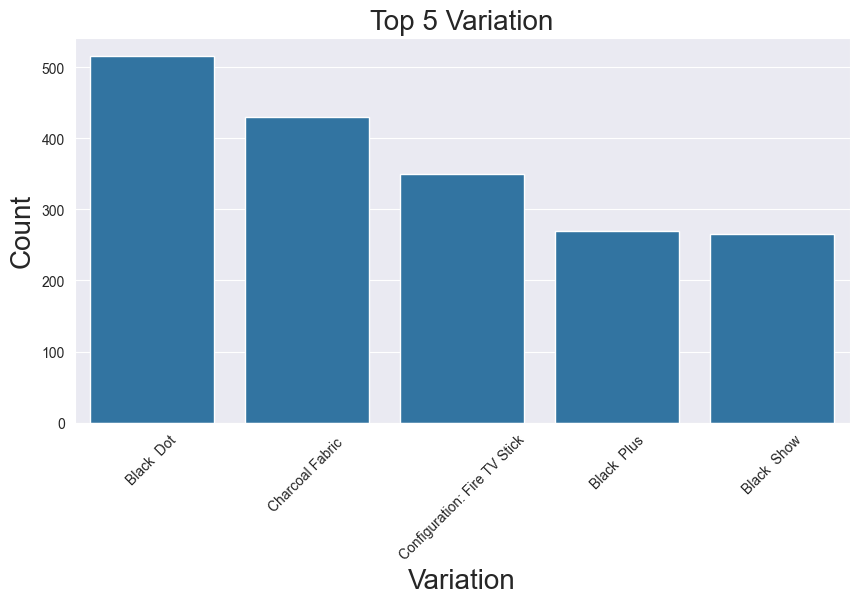

In [17]:
# Assuming df is already defined and contains the 'variation' column
variation_label = df.variation.value_counts()[:5]
print(variation_label)

# Plotting top 5 variation
plt.figure(figsize=(10, 5))
sns.barplot(x=variation_label.index, y=variation_label.values)  # Specify x and y explicitly
plt.xlabel('Variation', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.title('Top 5 Variation', fontsize=20)
plt.xticks(rotation=45)  # Rotate x labels if needed
plt.show()  # Add this line to display the plot


In [18]:
df.shape

(3150, 5)

In [21]:
# Adding a 'len' column for analyzing the length of the reviews
df['len'] = df['verified_reviews'].str.len().fillna(0)
df['len']


0        13.0
1         9.0
2       195.0
3       172.0
4         5.0
        ...  
3145     50.0
3146    135.0
3147    441.0
3148    380.0
3149      4.0
Name: len, Length: 3150, dtype: float64

In [23]:
''' displaying data based on len '''
df.groupby('len').describe().sample(10)

rating                                              feedback            \
       count      mean       std  min  25%  50%  75%  max    count      mean   
len                                                                            
287.0    3.0  4.666667  0.577350  4.0  4.5  5.0  5.0  5.0      3.0  1.000000   
215.0    3.0  2.666667  2.081666  1.0  1.5  2.0  3.5  5.0      3.0  0.333333   
223.0    3.0  5.000000  0.000000  5.0  5.0  5.0  5.0  5.0      3.0  1.000000   
134.0    9.0  4.222222  1.301708  2.0  4.0  5.0  5.0  5.0      9.0  0.777778   
301.0    1.0  5.000000       NaN  5.0  5.0  5.0  5.0  5.0      1.0  1.000000   
232.0    3.0  5.000000  0.000000  5.0  5.0  5.0  5.0  5.0      3.0  1.000000   
364.0    2.0  5.000000  0.000000  5.0  5.0  5.0  5.0  5.0      2.0  1.000000   
714.0    1.0  5.000000       NaN  5.0  5.0  5.0  5.0  5.0      1.0  1.000000   
31.0    33.0  4.787879  0.484612  3.0  5.0  5.0  5.0  5.0     33.0  1.000000   
376.0    1.0  1.000000       NaN  1.0  1.0  1.0  1.0  1.0      1.0  0.000000   

                                          
            std  min  25%  50%  75%  max  
len                                       
287.0  0.000000  1.0  1.0  1.0  1.0  1.0  
215.0  0.577350  0.0  0.0  0.0  0.5  1.0  
223.0  0.000000  1.0  1.0  1.0  1.0  1.0  
134.0  0.440959  0.0  1.0  1.0  1.0  1.0  
301.0       NaN  1.0  1.0  1.0  1.0  1.0  
232.0  0.000000  1.0  1.0  1.0  1.0  1.0  
364.0  0.000000  1.0  1.0  1.0  1.0  1.0  
714.0       NaN  1.0  1.0  1.0  1.0  1.0  
31.0   0.000000  1.0  1.0  1.0  1.0  1.0  
376.0       NaN  0.0  0.0  0.0  0.0  0.0

In [24]:
'''displaying the data according to the Ratings '''
df.groupby('rating').describe()

feedback                                        len              \
          count mean  std  min  25%  50%  75%  max   count        mean   
rating                                                                   
1         161.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   161.0  195.000000   
2          96.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    96.0  249.145833   
3         152.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0   152.0  207.296053   
4         455.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0   455.0  178.520879   
5        2286.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  2286.0  108.444007   

                                                       
               std  min    25%    50%     75%     max  
rating                                                 
1       212.371226  1.0  36.00  120.0  284.00  1124.0  
2       269.633903  0.0  78.75  163.0  309.25  1686.0  
3       272.194706  1.0  54.00  130.0  284.00  1954.0  
4       215.927849  1.0  34.00   99.0  241.00  1360.0  
5       152.116387  1.0  26.00   64.0  135.00  2851.0

In [25]:
''' displaying data based according to the feedback '''
df.groupby('feedback').describe()

rating                                                  len  \
           count      mean       std  min  25%  50%  75%  max   count   
feedback                                                                
0          257.0  1.373541  0.484688  1.0  1.0  1.0  2.0  2.0   257.0   
1         2893.0  4.737643  0.546544  3.0  5.0  5.0  5.0  5.0  2893.0   

                                                                   
                mean         std  min   25%    50%    75%     max  
feedback                                                           
0         215.225681  236.340053  0.0  53.0  137.0  289.0  1686.0  
1         124.659177  174.624491  1.0  29.0   69.0  154.0  2851.0

<Figure size 1000x500 with 0 Axes>

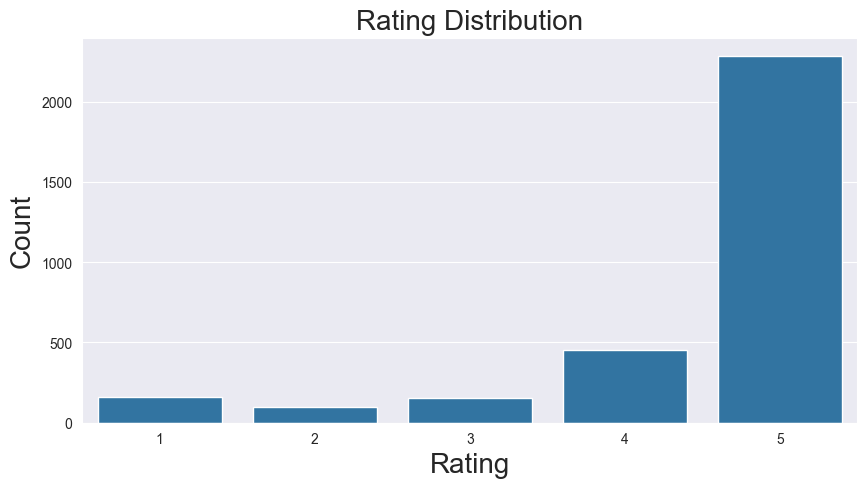

In [29]:
# Assuming rating_label is defined and contains the value counts
plt.figure(figsize=(10, 5))
sns.barplot(x=rating_label.index, y=rating_label.values)  # Specify x and y explicitly
plt.xlabel('Rating', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.title('Rating Distribution', fontsize=20)  # Optional: Add a title
plt.show()  # Display the plot


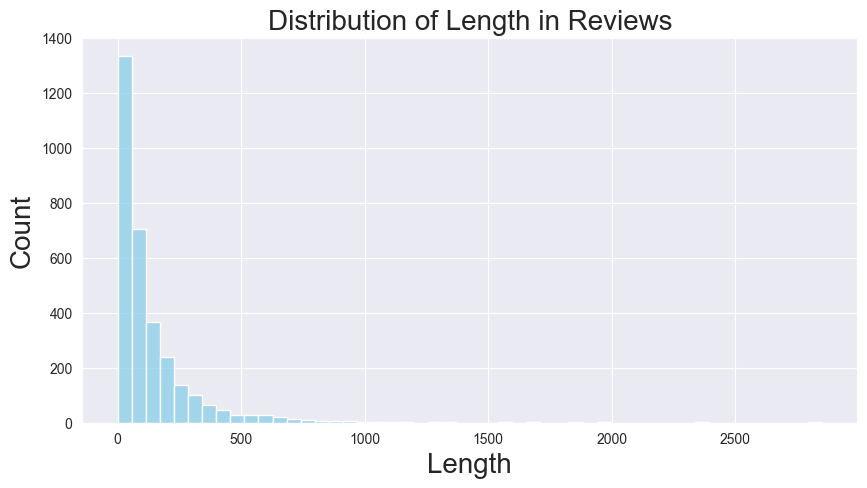

In [34]:
# Plot 2: Histogram of lengths of reviews
plt.figure(figsize=(10, 5))
sns.histplot(df['len'], bins=50, color='skyblue')
plt.xlabel('Length', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.title('Distribution of Length in Reviews', fontsize=20)
plt.show()  # Display the second plot


In [35]:
''' Let's Check some of the reviews according to thier lengths '''
df[df.len == 1]['verified_reviews'].iloc[0]

'😍'

In [36]:
df[df['len'] == 150]['verified_reviews'].iloc[0]

"Got this on Amazon prime with the ring pro. Work really great. Being the lazy guy I am I don't need to go see who at my door anymore while I'm gaming."

In [37]:
df[df['len'] == 50]['verified_reviews'].iloc[0]

'Yet another Exho for our home and love them all!!!'

In [38]:
df[df['len'] == 25]['verified_reviews'].iloc[0]

'I love it, wife hates it.'

<Figure size 1000x500 with 0 Axes>

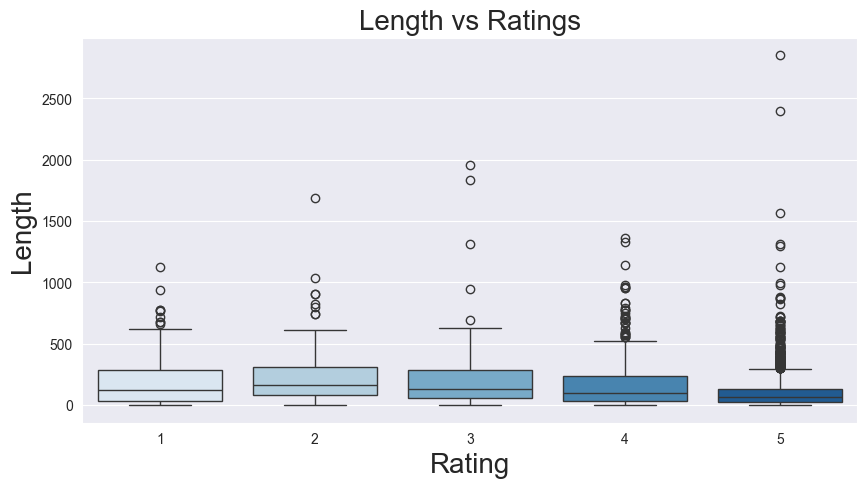

In [40]:
# Box plot
plt.figure(figsize=(10, 5))
sns.boxplot(x='rating', y='len', data=df, palette='Blues')  # Specify x and y explicitly
plt.title("Length vs Ratings", fontsize=20)
plt.xlabel('Rating', fontsize=20)
plt.ylabel('Length', fontsize=20)
plt.show()  # Display the plot


<Figure size 1000x500 with 0 Axes>

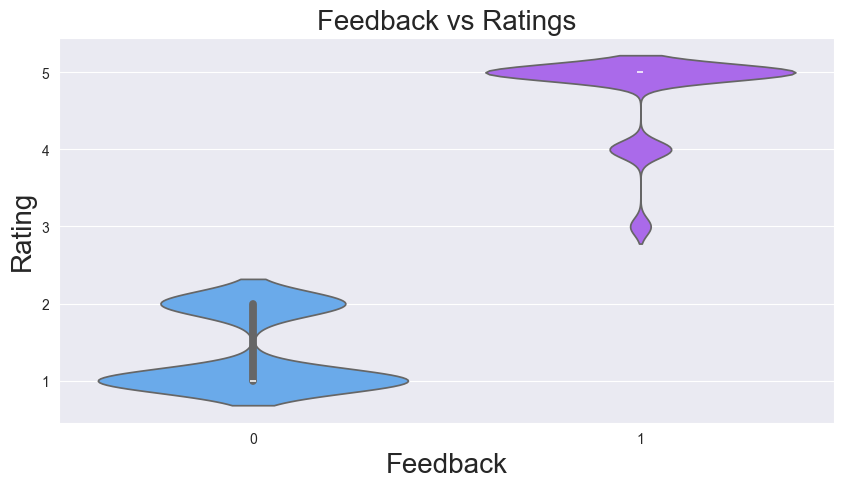

In [42]:
# Violin plot
plt.figure(figsize=(10, 5))
sns.violinplot(x='feedback', y='rating', data=df, palette='cool')  # Specify x and y explicitly
plt.title("Feedback vs Ratings", fontsize=20)
plt.xlabel('Feedback', fontsize=20)
plt.ylabel('Rating', fontsize=20)
plt.show()  # Display the plot


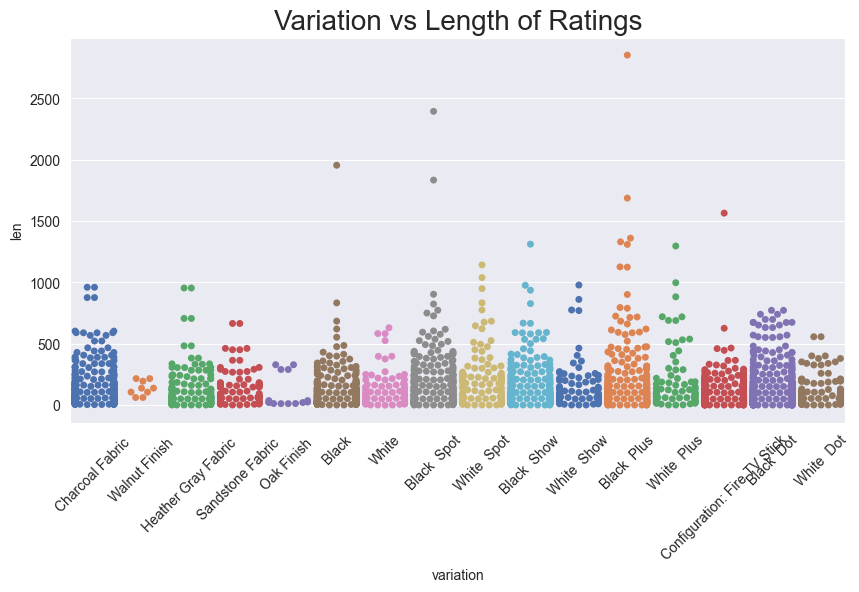

In [45]:
# Swarm plot
plt.figure(figsize=(10, 5))
sns.swarmplot(x='variation', y='len', data=df, palette='deep')  # Specify x and y explicitly
plt.title("Variation vs Length of Ratings", fontsize=20)
plt.xticks(rotation=45)  # Rotate x labels if needed
plt.show()  # Display the plot


<Figure size 1000x500 with 0 Axes>

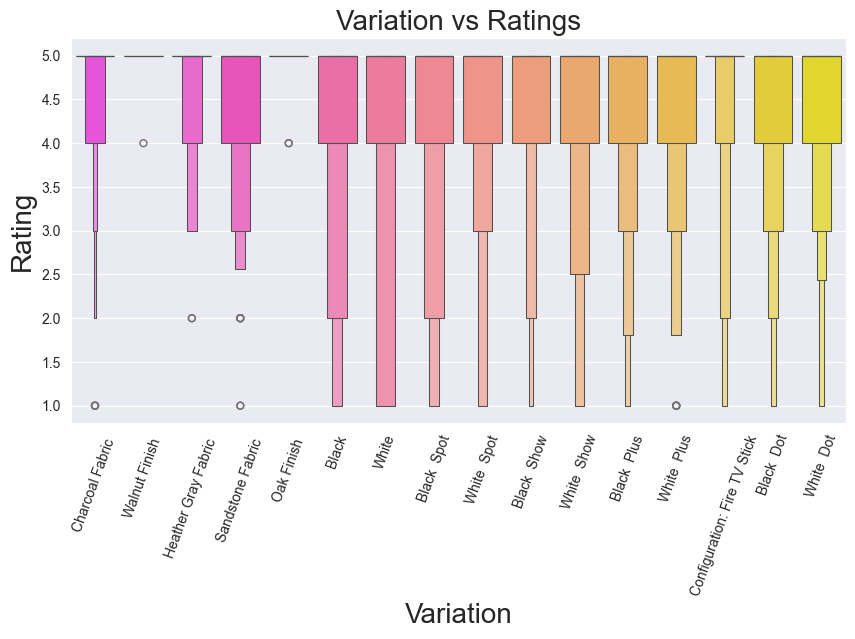

In [47]:
# Bivariate analysis using boxen plot
plt.figure(figsize=(10, 5))
sns.boxenplot(x='variation', y='rating', data=df, palette='spring')  # Specify x and y explicitly
plt.title("Variation vs Ratings", fontsize=20)
plt.xticks(rotation=70)  # Rotate x labels if needed
plt.xlabel('Variation', fontsize=20)
plt.ylabel('Rating', fontsize=20)
plt.show()  # Display the plot


In [62]:


# Preprocessing of text
# Fill NaN values with an empty string
df['verified_reviews'] = df['verified_reviews'].fillna('')

# CountVectorizer
count_vector = CountVectorizer(stop_words='english') 

# Fit and transform the verified_reviews
ws = count_vector.fit_transform(df['verified_reviews'])
s_w = ws.sum(axis=0)
w_f = [(w, s_w[0, idx]) for w, idx in count_vector.vocabulary_.items()]
w_f = sorted(w_f, key=lambda x: x[1], reverse=True)

# Creating DataFrame
freq = pd.DataFrame(w_f, columns=['word', 'freq'])

# Display the frequency DataFrame
print(freq.head())


    word  freq
0   love   956
1   echo   839
2  great   729
3  alexa   632
4  music   540


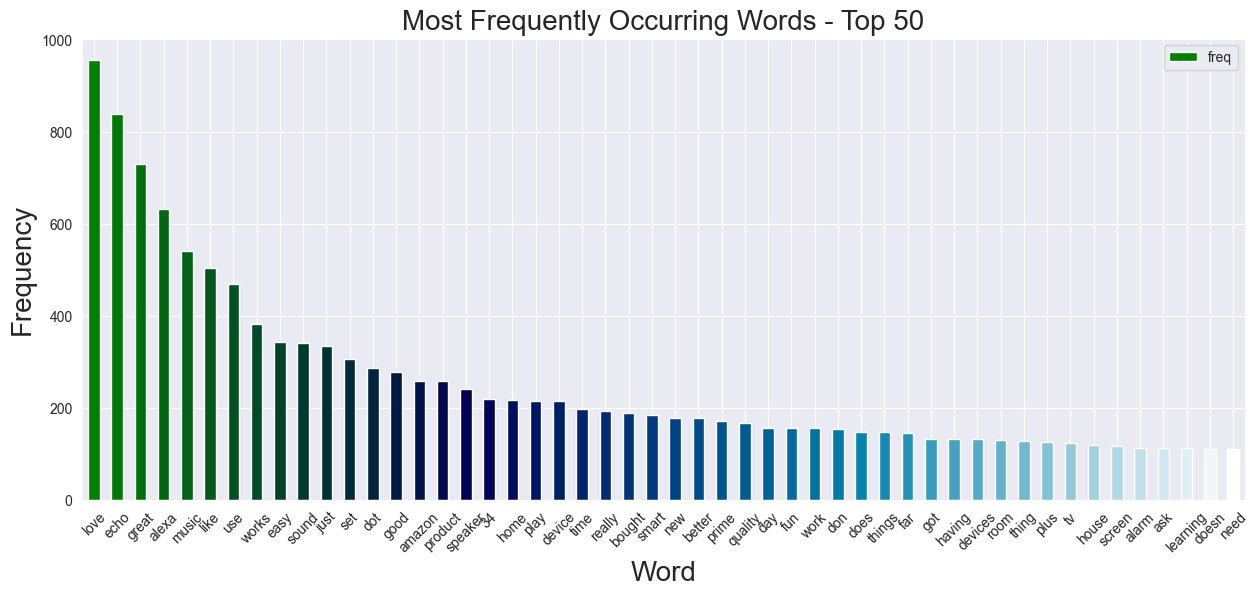

In [80]:

# Assuming 'freq' is a DataFrame with columns 'word' and 'freq'
# Example DataFrame creation (you should replace this with your actual DataFrame)
# freq = pd.DataFrame({'word': ['word1', 'word2', ...], 'freq': [10, 20, ...]})

# Bar plot of top 50 frequently occurring words
color = plt.cm.ocean(np.linspace(0, 1, 50))  # Adjusted to 50 for top 50 words
freq.head(50).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color=color)
plt.title("Most Frequently Occurring Words - Top 50", fontsize=20)
plt.xlabel('Word', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show()  # Display the plot


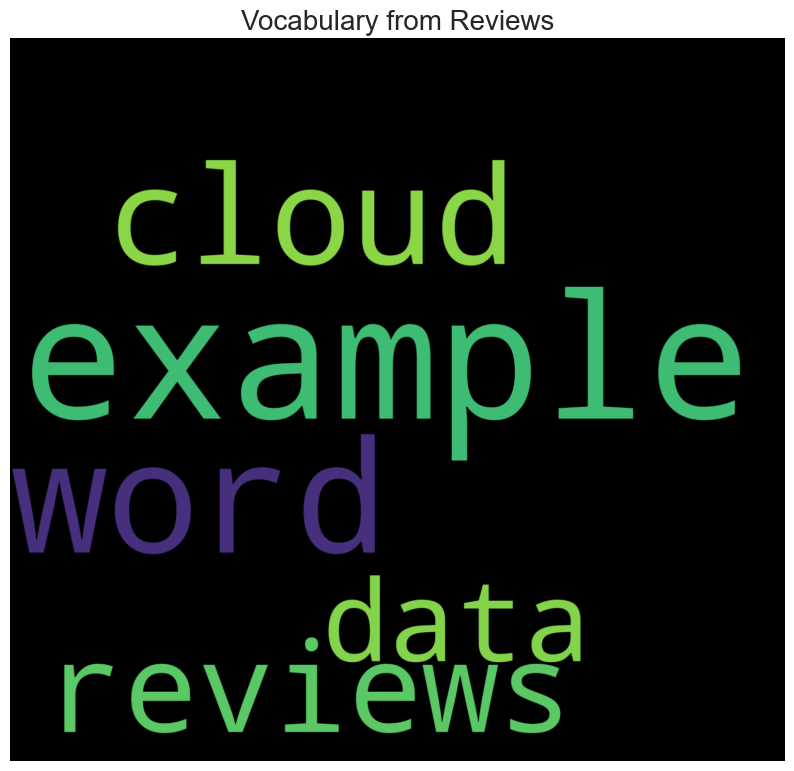

In [94]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming w_f is a dictionary with word frequencies
# Example: w_f = {'word1': 100, 'word2': 80, 'word3': 60, ...}
w_f = {
    'example': 100,
    'word': 80,
    'cloud': 60,
    'reviews': 50,
    'data': 40,
    # Add more words and their frequencies
}

# Generate the word cloud
word_cloud = WordCloud(background_color='black', width=1500, height=1400).generate_from_frequencies(w_f)

# Plotting the word cloud
plt.figure(figsize=(10, 10))
plt.axis('off')  # Turn off the axis
plt.imshow(word_cloud, interpolation='bilinear')  # Use interpolation for better quality
plt.title("Vocabulary from Reviews", fontsize=20)
plt.show()  # Display the plot


In [98]:
import re
import pandas as pd
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

# Assuming df is a pandas DataFrame containing a column 'verified_reviews'
c = []

# Initialize the Porter Stemmer
ps = PorterStemmer()
# Load stopwords
sw = set(stopwords.words('english'))
sw.remove('not')  # Keep 'not' in the stopwords

for i in range(len(df)):  # Use len(df) to avoid hardcoding the range
    review = df['verified_reviews'][i]
    
    # Check if the review is a string
    if isinstance(review, str):
        # Removing characters except a-z and A-Z
        r = re.sub('[^a-zA-Z]', ' ', review)
        # Converting every word into lower case
        r = r.lower()
        # Splitting text
        r = r.split()
        # Applying stemming and removing stopwords
        r = [ps.stem(word) for word in r if word not in sw]
        # Joining the processed words back into a single string
        r = ' '.join(r)
        c.append(r)
    else:
        # If it's not a string, you can choose to append an empty string or skip
        c.append('')  # or continue to skip this entry


In [99]:
''' count vectorizer '''
count_vector = CountVectorizer(max_features=2500) 

''' independent and dependent variables '''
X = count_vector.fit_transform(c).toarray()
y = df.iloc[:, 4].values

''' checking shape '''
print(X.shape)
print(y.shape)

(3150, 2500)
(3150,)


In [100]:
''' train test split '''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [101]:
print("shape of X_train: ", X_train.shape)
print("shape of X_test: ", X_test.shape)

shape of X_train:  (2362, 2500)
shape of X_test:  (788, 2500)


In [104]:
''' Min Max Scaler '''
min_max_sc = MinMaxScaler()

X_train = min_max_sc.fit_transform(X_train)
X_test = min_max_sc.transform(X_test)

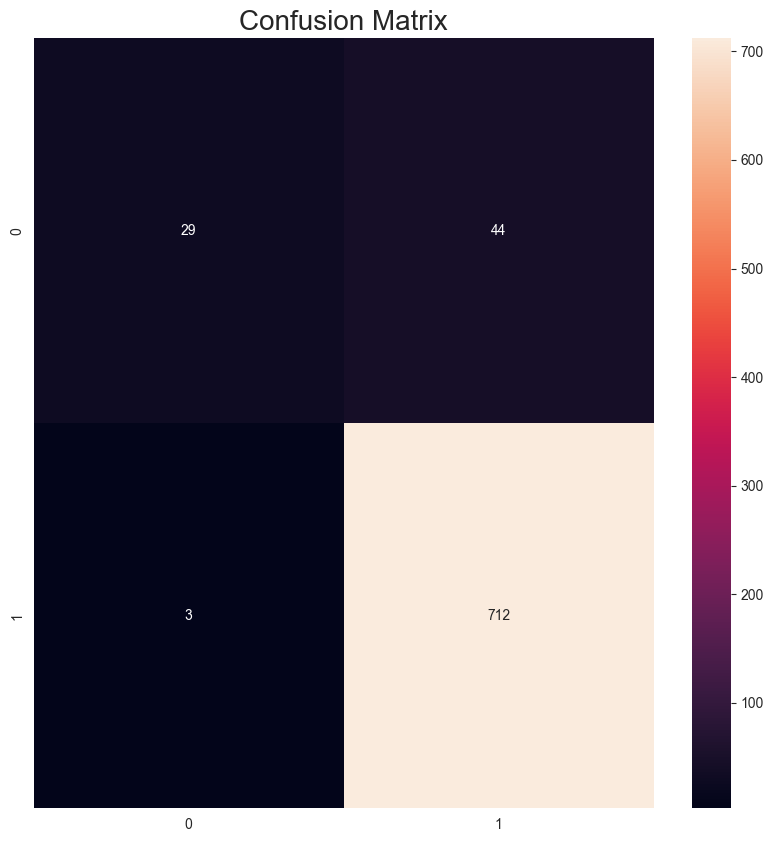

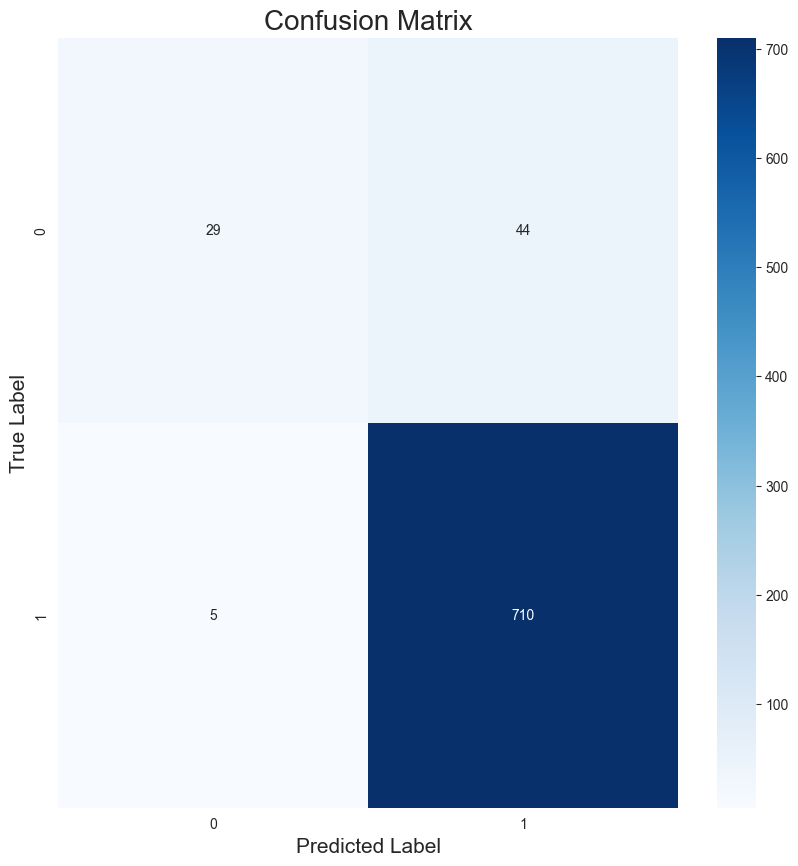

In [106]:

# Initialize the Random Forest Classifier
rf = RandomForestClassifier()

# Fit the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix', fontsize=20)
plt.xlabel('Predicted Label', fontsize=15)
plt.ylabel('True Label', fontsize=15)
plt.show()  # Ensure to call plt.show() to display the plot


In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import pandas as pd

# Load sample data (Iris dataset)
data = load_iris()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier
rf = RandomForestClassifier()

# Define the hyperparameter grid
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

# Initialize Grid Search CV
grid_cv = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, verbose=1, scoring='accuracy', n_jobs=-1, 
                       return_train_score=True)

# Fit the model on the training data
print("Starting Grid Search...")
grid_cv.fit(X_train, y_train.ravel())  # Ensure y_train is a 1D array
print("Grid Search Completed.")

# Print the best parameters and best score
print("Best Parameters:", grid_cv.best_params_)
print("Best Score:", grid_cv.best_score_)


Starting Grid Search...
Fitting 10 folds for each of 8 candidates, totalling 80 fits


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24996\3772359134.py:32: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  grid_cv.fit(X_train, y_train.ravel())  # Ensure y_train is a 1D array


Grid Search Completed.
Best Parameters: {'bootstrap': True, 'max_depth': 80, 'min_samples_split': 8, 'n_estimators': 100}
Best Score: 0.9416666666666667


In [7]:
print("Best Parameter : {}".format(grid_cv.best_params_))

Best Parameter : {'bootstrap': True, 'max_depth': 80, 'min_samples_split': 8, 'n_estimators': 100}


In [8]:
rf_cv = RandomForestClassifier(bootstrap=True, max_depth=80, min_samples_split=8, n_estimators=300)

''' fit on data '''
rf_cv.fit(X_train, y_train)

''' prediction '''
pred = rf_cv.predict(X_test)

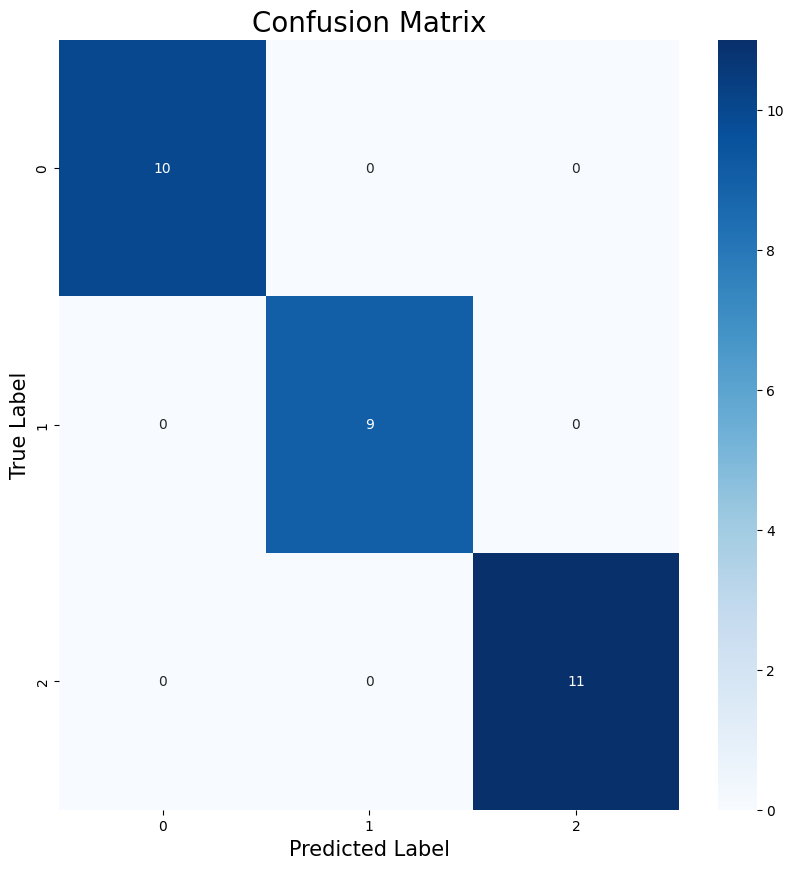

In [11]:


# Assuming y_test and pred are already defined
# Generate the confusion matrix
cm = confusion_matrix(y_test, pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')  # Added colormap for better visualization
plt.title('Confusion Matrix', fontsize=20)
plt.xlabel('Predicted Label', fontsize=15)
plt.ylabel('True Label', fontsize=15)
plt.show()  # Ensure to call plt.show() to display the plot
